In [ ]:
# @title Copyright & License (click to expand)
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vertex AI LLM Reinforcement Learning from Human Feedback

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/generative_ai/rlhf_tune_llm.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/generative_ai/rlhf_tune_llm.ipynb">
        <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
    <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/official/generative_ai/rlhf_tune_llm.ipynb">
       <img src="https://www.gstatic.com/cloud/images/navigation/vertex-ai.svg" alt="Vertex AI logo">Open in Vertex AI Workbench
    </a>
</table>

## Overview

This tutorial demonstrates how to use Vertex AI RLHF to tune a large-language model (LLM). This workflow improves a model's accuracy by fine-tuning a base model with a training dataset.

*Preview releases are covered by the Pre-GA Offerings Terms of the Google Cloud Platform Terms of Service. They are not intended for production use or covered by any SLA, support obligation, or deprecation policy and might be subject to backward-incompatible changes.*

Learn more about [Tune text models by using RLHF tuning](https://cloud.google.com/vertex-ai/docs/generative-ai/models/tune-text-models-rlhf).

### Objective

In this tutorial, you will use `Vertex AI RLHF` to tune and deploy a large language model model.


This tutorial uses the following Google Cloud ML services:

- `Vertex AI RLHF`
- `Vertex AI Pipelines`


The steps performed include:

- Set the number of model tuning steps.
- Create Vertex AI Pipeline job using a predefined template for tuning.
- Execute the pipeline using `Vertex AI Pipelines`.
- Perform online prediction with the tuned model.

### Prepare your inputs

In the sample below, you will run RLHF training on Google PaLM 2 Bison model. A list of supported models, hardware and regions can be found as follows. Tuning jobs that run in us-central1 will use 8 Nvidia A100 80GB. Jobs that run in europe-west4 will use 64 v3 TPUs.

**Table 1. Supported models, hardware and regions**

| large_model_reference | supported accelerator_type | supported region |
|---|---|---|
|  `text-bison@001` | `TPU_V3`, `NVIDIA_TESLA_A100` | europe-west4, us-central1 |
|  `chat-bison@001` | `TPU_V3`, `NVIDIA_TESLA_A100` | europe-west4, us-central1 |
|  `t5-small` | `TPU_V3`, `NVIDIA_TESLA_A100` | europe-west4, us-central1 |
|  `t5-large` | `TPU_V3` | europe-west4 |
|  `t5-xl` | `TPU_V3` | europe-west4 |
|  `t5-xxl` | `TPU_V3` | europe-west4 |

The workflow takes the following inputs:

* **prompt_dataset**: Required, `str`. Cloud storage path to an unlabled JSONL dataset that contains prompts used for reinforcement learning. Dataset format depends on whether you are tuning a text or chat reference model:
> Datasets used to tune text models must contain an `input_text` field that contains the prompt.
> * For example: `{"input_text": "Create a desription for Plantation Palms."}`
> * Download the [sample text prompt dataset](https://pantheon.corp.google.com/storage/browser/vertex-ai/generative-ai/rlhf/text_small/reddit_tfds/train?pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&e=13802955&jsmode=O&mods=-ai_platform_fake_service&project=vertex-ai&prefix=&forceOnObjectsSortingFiltering=false) to see more examples.

> Datasets used to tune chat models must contain at least 1 message in a `messages` field.
> * Each message must be valid JSON that contains `author` and `content` fields, where valid `author` values are `user` and `assistant` and `content` must be non-empty.
> * Each row may contain multiple messages, but the first and last author must be the `user`.
> * An optional `context` field may be provided for each example in a chat dataset. If provided, the `context` will preprended to the message `content`.
> * The `instruction` serves as the default context. (Useful if most messages use the same system-level context.) Any context provided in the example will override the default value.
> * For example: `{"context": "I am a helpful assistant that can answer questions about Plantation Palms.", "messages": [{"author": "user", "content": "Hello"}, {"author": "assistant", "content": "Hello, how can I help you?"}, {"author": "user", "content": "Tell me about Plantation Palms."}]}`

* **preference_dataset**: Required, `str`. Cloud storage path to a human preference dataset used to train a reward model. Preference datasets must contain all required fields from the prompt dataset plus additional candidate and choice fields:
> * `candidate_0`, `candidate_1` fields containing candidate responses.
> * A `choice` field that specifies which candidate is preferred. This field is an integer `0` or `1`. `0` means `candidate_0` is preferred, `1` means `candidate_1` is preferred.

> * An example row from a text dataset: `{"input_text": "Create a description for Plantation Palms.", "candidate_0": "Enjoy some fun in the sun at Gulf Shores.", "candidate_1": "A Tranquil Oasis of Natural Beauty.", "choice": 0}`
> * Download the [sample text preference dataset](https://pantheon.corp.google.com/storage/browser/vertex-ai/generative-ai/rlhf/text_small/reddit_tfds/train?pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&e=13802955&jsmode=O&mods=-ai_platform_fake_service&project=vertex-ai&prefix=&forceOnObjectsSortingFiltering=false) to see more examples.

> * An example row from a chat dataset: `{"context": "I am a helpful assistant that can answer questions about Plantation Palms.", "messages": [{"author": "user", "content": "Hello"}, {"author": "assistant", "content": "Hello, how can I help you?"}, {"author": "user", "content": "Create a description for Plantation Palms.", "candidate_0": "Enjoy some fun in the sun at Gulf Shores.", "candidate_1": "A Tranquil Oasis of Natural Beauty.", "choice": 0}]}`

* **eval_dataset**: Optional, `str`. Cloud storage path to the unlabeled dataset you want to do prediction on. If provided, inference will be performed on this dataset after training. Its format is exactly the same as **prompt_dataset**.

* **large_model_reference**: Required, `str`. Name of the base model. In this example, we use `text-bison@001`. Valid values are listed in the table above.

* **model_display_name**: Optional, `str`. Name of the fine-tuned model shown in the Model Registry. If not provided, a default name will be created.

* **reward_model_train_steps**: Optional, `int`. Number of steps to use when training a reward model. Default value is 1000.

* **reinforcement_learning_train_steps**: Optional, `int`. Number of reinforcement learning steps to perform when tuning a base model. Default value is 1000.

* **prompt_sequence_length**: Optional, `int`. Maximum tokenized sequence length for input text. Higher values increase memory overhead. This value should be at most `8192`. Default value is `512`.

* **target_sequence_length**: Optional, `int`. Maximum tokenized sequence length for target text. Higher values increase memory overhead. This value should be at most `1024`. Default value is `64`.

* **reward_model_learning_rate_multiplier**: Optional, `float`. Constant used to adjust the base learning rate used when training a reward model. Multiply by a number > 1 to increase the magnitude of updates applied at each training step or multiply by a number < 1 to decrease the magnitude of updates. Default value is `1.0`.

* **reinforcement_learning_rate_multiplier**: Optional, `float`. Constant used to adjust the base learning rate used during reinforcement learning. Multiply by a number > 1 to increase the magnitude of updates applied at each training step or multiply by a number < 1 to decrease the magnitude of updates. Default value is `1.0`.

* **kl_coeff**: Optional, `float`. Coefficient for KL penalty. This regularizes the policy model and penalizes if it diverges from its initial distribution. If set to 0, the reference language model is not loaded into memory. Default value is `0.1`.

* **instruction**: Optional, `str`. This field lets the model know what task it needs to perform. Base models have been trained over a large set of varied instructions. You can give a simple and intuitive description of the task and the model will follow it, e.g. `Classify this movie review as positive or negative` or `Translate this sentence to Danish`. See [here](https://ai.googleblog.com/2021/10/introducing-flan-more-generalizable.html) for more details on the instruction-tuned models. Do not specify this if your dataset already prepends the instruction to the inputs field.

### A Note on designing your prompts

All prompt design techniques can be used with RLHF pipelines. If you are tuning `text-bison@001`, use the prompt that works with the un-tuned model as your `instruction` in the datasets.

### A Note on choosing train_steps

Choosing a suitable value for the number of train steps can help avoid overfitting.

* **reward_model_train_steps**: This depends on the size of your "comparison dataset". Usually, the model should train over the comparison dataset for 20-30 times for best results.

* **reinforcement_learning_train_steps**: This depends on the size of your prompt dataset. Usually, the model should train over the prompt dataset for roughly 10-20 times, but beware, if given too many training steps, the policy model may figure out a way exploit the reward and exhibit undesired behavior (i.e. "reward hacking").

The calculator below can help you compute these numbers.

In [ ]:
# Please REPLACE with your own parameters for:
# - N_COMPARISON_DATASET_EXAMPLES
# - N_REWARD_MODEL_TRAINER_EPOCHS
# - N_PROMPT_DATASET_EXAMPLES
# - N_REINFORCER_EPOCHS
# - BATCH_SIZE

import math

# This is your "preference dataset" size.
N_PREFERENCE_DATASET_EXAMPLES = 3000
# An epoch refers to one full cycle through the training dataset.
N_REWARD_MODEL_TRAIN_EPOCHS = 30

# This is your "prompt dataset" size.
N_PROMPT_DATASET_EXAMPLES = 2000
# An epoch refers to one full cycle through the training dataset.
N_REINFORCEMENT_LEARNING_TRAIN_EPOCHS = 10

BATCH_SIZE = 64  # We use fixed batch_size=64 under the hood.

reward_model_train_steps = math.ceil(
    N_PREFERENCE_DATASET_EXAMPLES * N_REWARD_MODEL_TRAIN_EPOCHS / BATCH_SIZE
)  # 3000 * 30 / 64 = 1407

reinforcement_learning_train_steps = math.ceil(
    N_PROMPT_DATASET_EXAMPLES * N_REINFORCEMENT_LEARNING_TRAIN_EPOCHS / BATCH_SIZE
)  # 2000 * 10 / 64 = 313

print(f"{reward_model_train_steps=}")
print(f"{reinforcement_learning_train_steps=}")

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing), [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Installation

Install the following packages required to execute this notebook.

In [ ]:
! pip3 install --upgrade --quiet google-cloud-aiplatform \
                                 google-cloud-pipeline-components \
                                 kfp

### Colab only: Uncomment the following cell to restart the kernel

Automatically restart kernel after installs so that your environment can access the new packages

In [ ]:
# import IPython

# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

## Before you begin

### Set your project ID

**If you don't know your project ID**, try the following:
* Run `gcloud config list`.
* Run `gcloud projects list`.
* See the support page: [Locate the project ID](https://support.google.com/googleapi/answer/7014113)

In [ ]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}

# Set the project id
! gcloud config set project {PROJECT_ID}

#### Region

You can also change the `REGION` variable used by Vertex AI. For preview, only `us-central1` and `europe-west4` are supported. Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [ ]:
REGION = "europe-west4"

### Authenticate your Google Cloud account

Depending on your Jupyter environment, you may need to authenticate manually. Follow the relevant instructions below.

#### Vertex AI Workbench
Do nothing as you are already authenticated.

#### Local JupyterLab instance

**1. Uncomment and run:**

In [ ]:
# ! gcloud auth login

**2. Colab, uncomment and run:**

In [ ]:
# from google.colab import auth
# auth.authenticate_user()

**3. Service account or other**
* See how to grant Cloud Storage permissions to your service account at https://cloud.google.com/storage/docs/gsutil/commands/iam#ch-examples.

### Create a Cloud Storage bucket

Define a storage bucket to store pipeline artifacts.

In [ ]:
BUCKET_URI = f"gs://your-bucket-name-{PROJECT_ID}-unique"  # @param {type:"string"}

**Only if your bucket doesn't exist already**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
! gsutil mb -l {REGION} -p {PROJECT_ID} {BUCKET_URI}

#### Service Account

A service account is needed to create Vertex AI Pipeline jobs. If you don't know your service account, run the following gcloud command to obtain your Compute Engine default service account.

In [ ]:
SERVICE_ACCOUNT = "[your-service-account]"  # @param {type:"string"}

In [ ]:
import sys

IS_COLAB = "google.colab" in sys.modules
if (
    SERVICE_ACCOUNT == ""
    or SERVICE_ACCOUNT is None
    or SERVICE_ACCOUNT == "[your-service-account]"
):
    # Get your service account from gcloud
    if not IS_COLAB:
        shell_output = !gcloud auth list 2>/dev/null
        SERVICE_ACCOUNT = shell_output[2].replace("*", "").strip()

    else:  # IS_COLAB:
        shell_output = ! gcloud projects describe $PROJECT_ID --format="value(projectNumber)"
        project_number = shell_output[0]
        SERVICE_ACCOUNT = f"{project_number}-compute@developer.gserviceaccount.com"

    print("Service Account:", SERVICE_ACCOUNT)

#### Set service account access for Vertex AI Pipelines

Run the following commands to grant your service account access to read and write pipeline artifacts in the bucket that you created in the previous step. You only need to run this step once per service account.

In [ ]:
! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectCreator $BUCKET_URI

! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectViewer $BUCKET_URI

### Set up variables

Next, set up some variables used throughout the tutorial.
### Import libraries and define constants

In [ ]:
import os

import google.cloud.aiplatform as aiplatform
from google_cloud_pipeline_components.preview.llm import rlhf_pipeline
from kfp import compiler

## Initialize Vertex AI SDK for Python

Initialize the Vertex AI SDK for Python for your project and corresponding bucket.

In [ ]:
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_URI)

## Compile the RLHF Pipeline

Compile the pipeline into a YAML file that will be submitted to Vertex AI.

In [ ]:
RLHF_PIPELINE_PKG_PATH = "rlhf_pipeline.yaml"

compiler.Compiler().compile(
    pipeline_func=rlhf_pipeline, package_path=RLHF_PIPELINE_PKG_PATH
)

## Construct the Pipeline Job and Run on Vertex AI

Define a pipeline job with the following code, which will:

- load the pipeline template that was compiled in the previous step, and
- set pipeline parameters. (See [Prepare your inputs](https://colab.research.google.com/drive/1SGSTAW3dcANbU_d3g5mSGCN9LXf5cA1p?resourcekey=0-NAfp-Rrb9piBiJbvqa6bqA#scrollTo=aef4f59195ad&line=61&uniqifier=1) section above for the definition of these parameters.)


In [ ]:
# Create a job via the pipeline template compiled in the previous step:
job = aiplatform.PipelineJob(
    display_name="tutorial-rlhf-tuning",
    pipeline_root=f"{BUCKET_URI}/rlhf",
    template_path=RLHF_PIPELINE_PKG_PATH,
    parameter_values={
        "preference_dataset": "gs://vertex-ai/generative-ai/rlhf/text_small/summarize_from_feedback_tfds/comparisons/train/*.jsonl",
        "prompt_dataset": "gs://vertex-ai/generative-ai/rlhf/text_small/reddit_tfds/train/*.jsonl",
        "large_model_reference": "text-bison@001",  # See table 1 for values
        "model_display_name": "my_rlhf_tutorial_model",  # Optional. If omitted, a default model_display_name will be created.
        "reward_model_train_steps": 100,  # Please remember to read "A Note on choosing train_steps" section.
        "reinforcement_learning_train_steps": 100,  # Please remember to read "A Note on choosing train_steps" section.
        "prompt_sequence_length": 512,
        "target_sequence_length": 64,
        "reward_model_learning_rate_multiplier": 1.0,
        "reinforcement_learning_rate_multiplier": 1.0,
        "kl_coeff": 0.1,
        "instruction": "Summarize in less than 50 words.",
    },
)

### Run the pipeline using Vertex AI Pipelines

Execute the following cell to run the pipeline on Vertex AI.

In [ ]:
job.run()

### View pipeline job in UI

Go to "Vertex AI Pipelines" in the Google Cloud UI to view the pipeline job. When the pipeline completes, click on the **Reinforcer** step. In the output parameters section you should see the output model's Cloud Storage path.
* If you tuned an open-source model (like the T5 models), the output model will be in your project's Cloud Storage buckets. You will be able to download the tuned model.
* If you tuned PaLM 2 models, the output model will be in a restricted-access Cloud Storage bucket. You won't be able to download the tuned model.

### Look at training loss and reward using Tensorboard

The **RewardModelTrainer** and **Reinforcer** output the training time `rank_loss`, `reward`, `kl_loss` to tensorboard to help you examine training curves and decide how to tune hyper-parameters.

Click on the **tensorboard_metrics** > `URI` attached to **RewardModelTrainer** and **Reinforcer**. If you encounter "❗ Requested entity was not found", this is a known issue. Hit the backarrow at the top of the page, then > `tensorboard_metrics/` > `train/` > some filename that looks like `events.out.tfevents.*-w-1.1.0.v2`. This is the tensorboard file. Download the tensorboard files from both RewardModelTrainer and Reinforcer.

Visualize the tensorboards using the [tensorboard python package](https://pypi.org/project/tensorboard/). It will give you some loss curves that looks like the curves below.


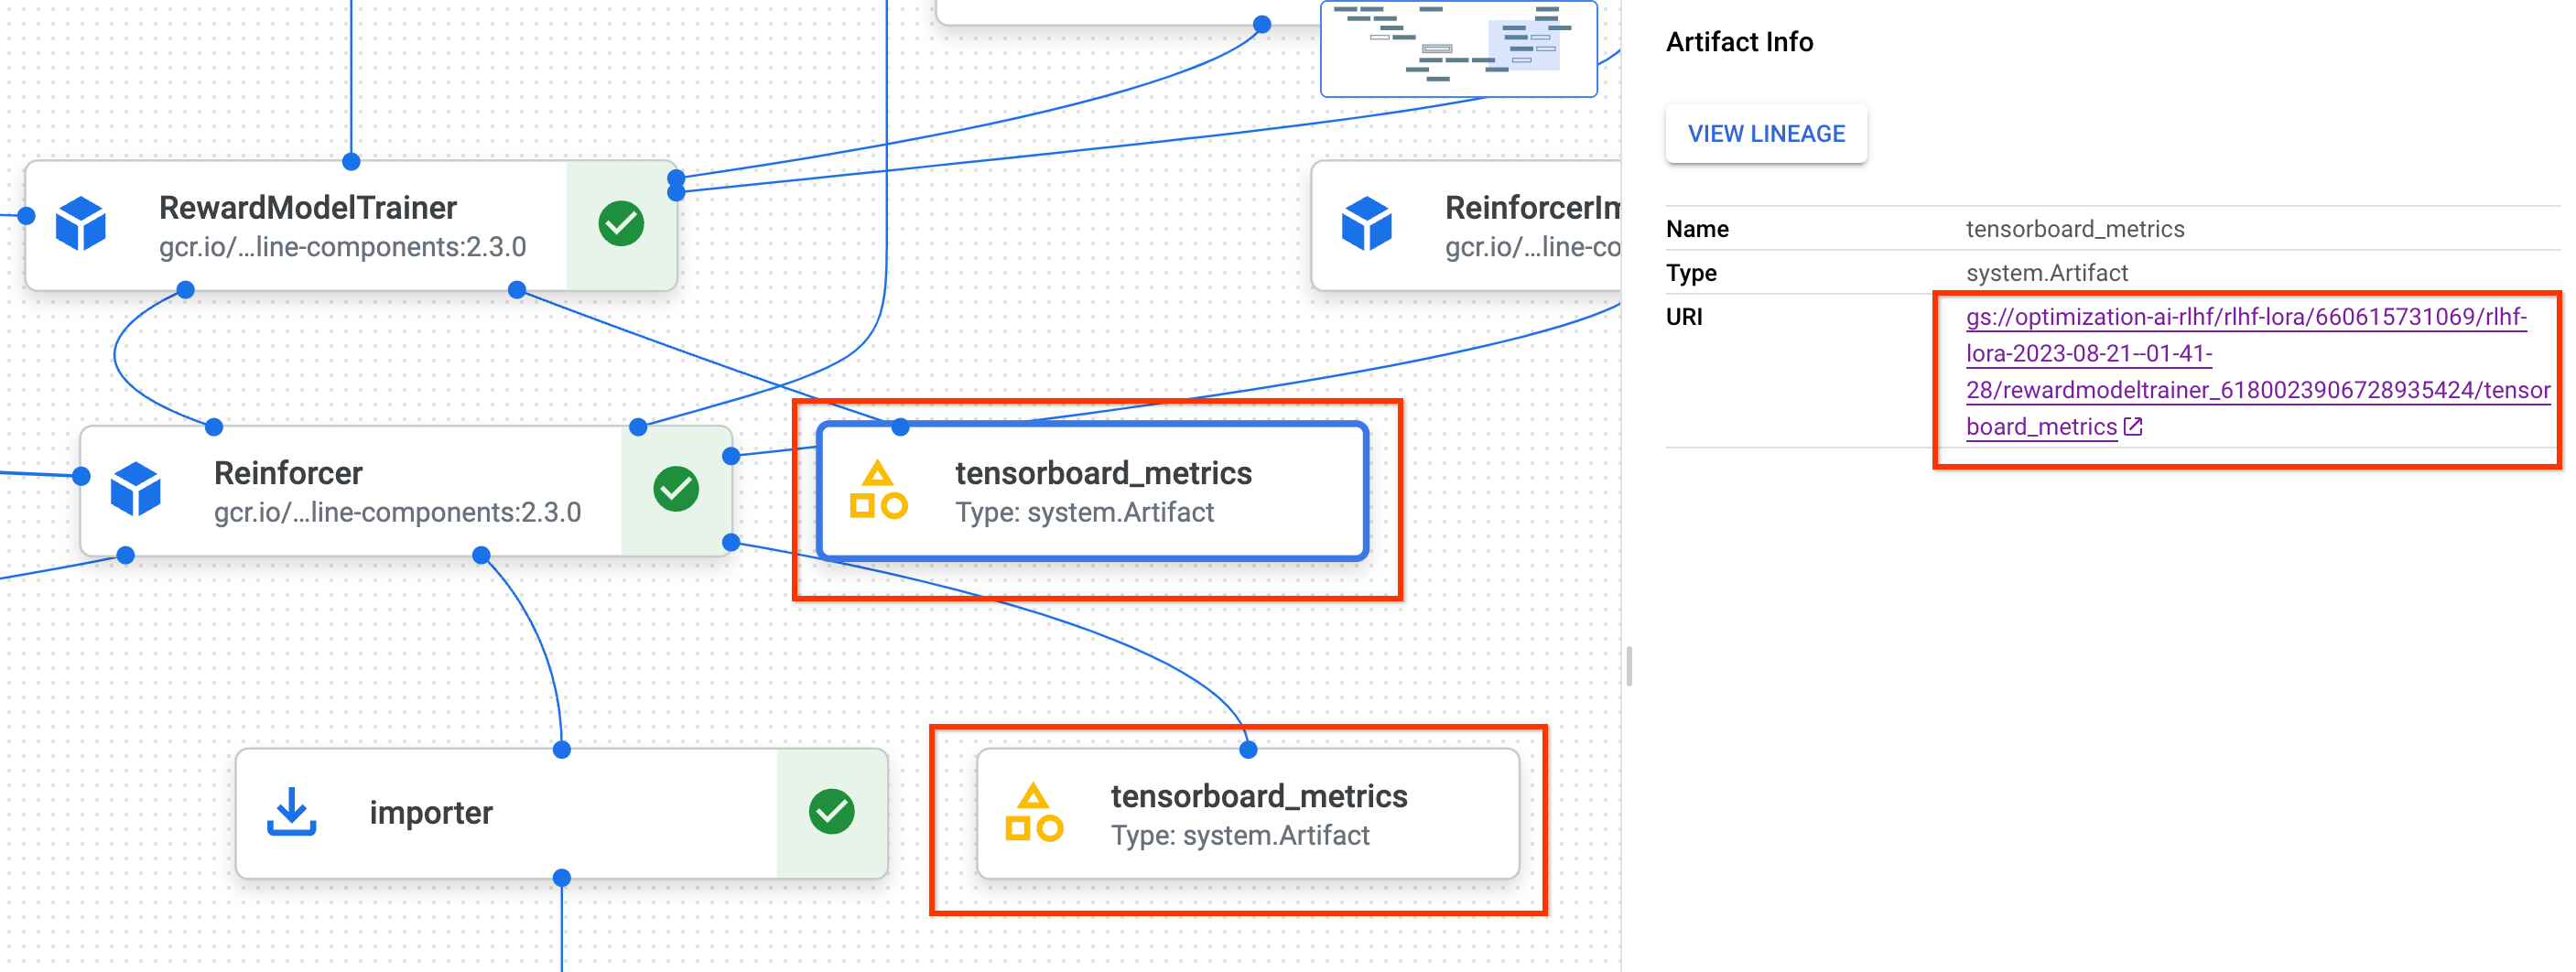

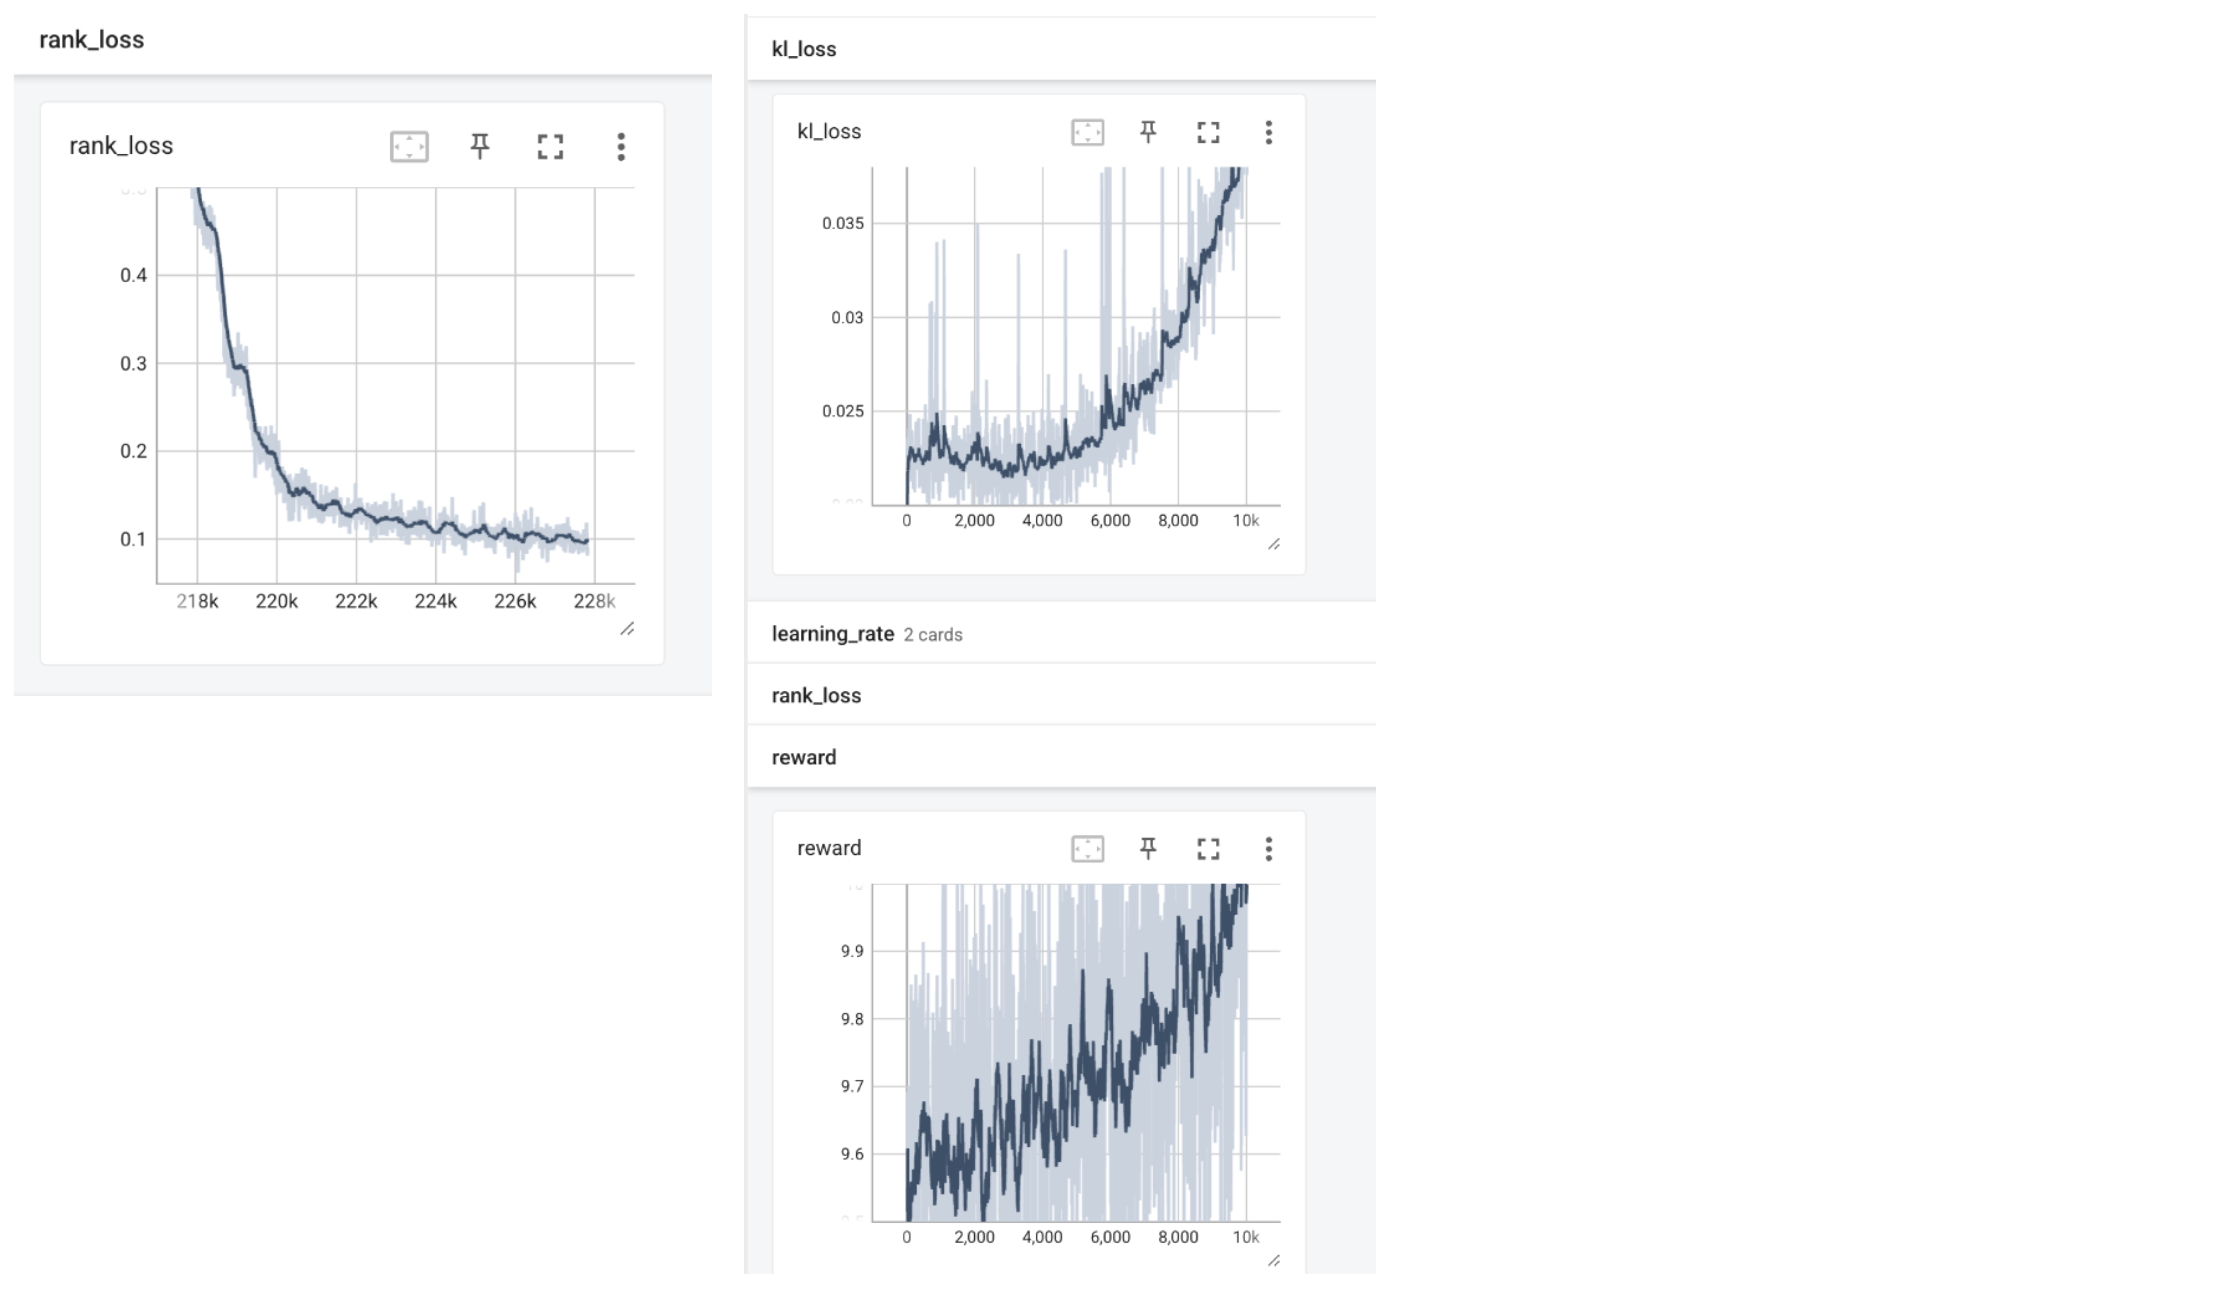

## Get Predictions from Tuned Models
The recommened way to get predictions from tuned models depends on whether you are working with a first-party or third-party model. For first-party models, e.g. `text-bison@001`, you can get predictions using [Batch Prediction](https://cloud.google.com/vertex-ai/docs/predictions/get-batch-predictions) or [Online Prediction](https://cloud.google.com/vertex-ai/docs/predictions/get-online-predictions), and for third-party models, we provide a bulk inference pipeline that can be used with the tuned-model checkpoint. Examples for both model types are in subsequent sections below.

### Bulk Inference for Third-Party Models
In this section we show how to use the bulk inference pipeline to get predictions from a tuned `t5-small` model. This method will not work for first-party models, e.g. `text-bison@001`. Follow the example in the next section to get predictions from those models.

To perform bulk inference you will need the path to your tuned third-party model, which can be found in the Vertex Pipelines UI under **Reinforcer** > **Output Parameters** > `output_model_path`. Once you have the model path, follow the directions in the [Bulk Inference notebook](https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/generative_ai/batch_eval_llm.ipynb) to generate offline predictions from a tuned model checkpoint.

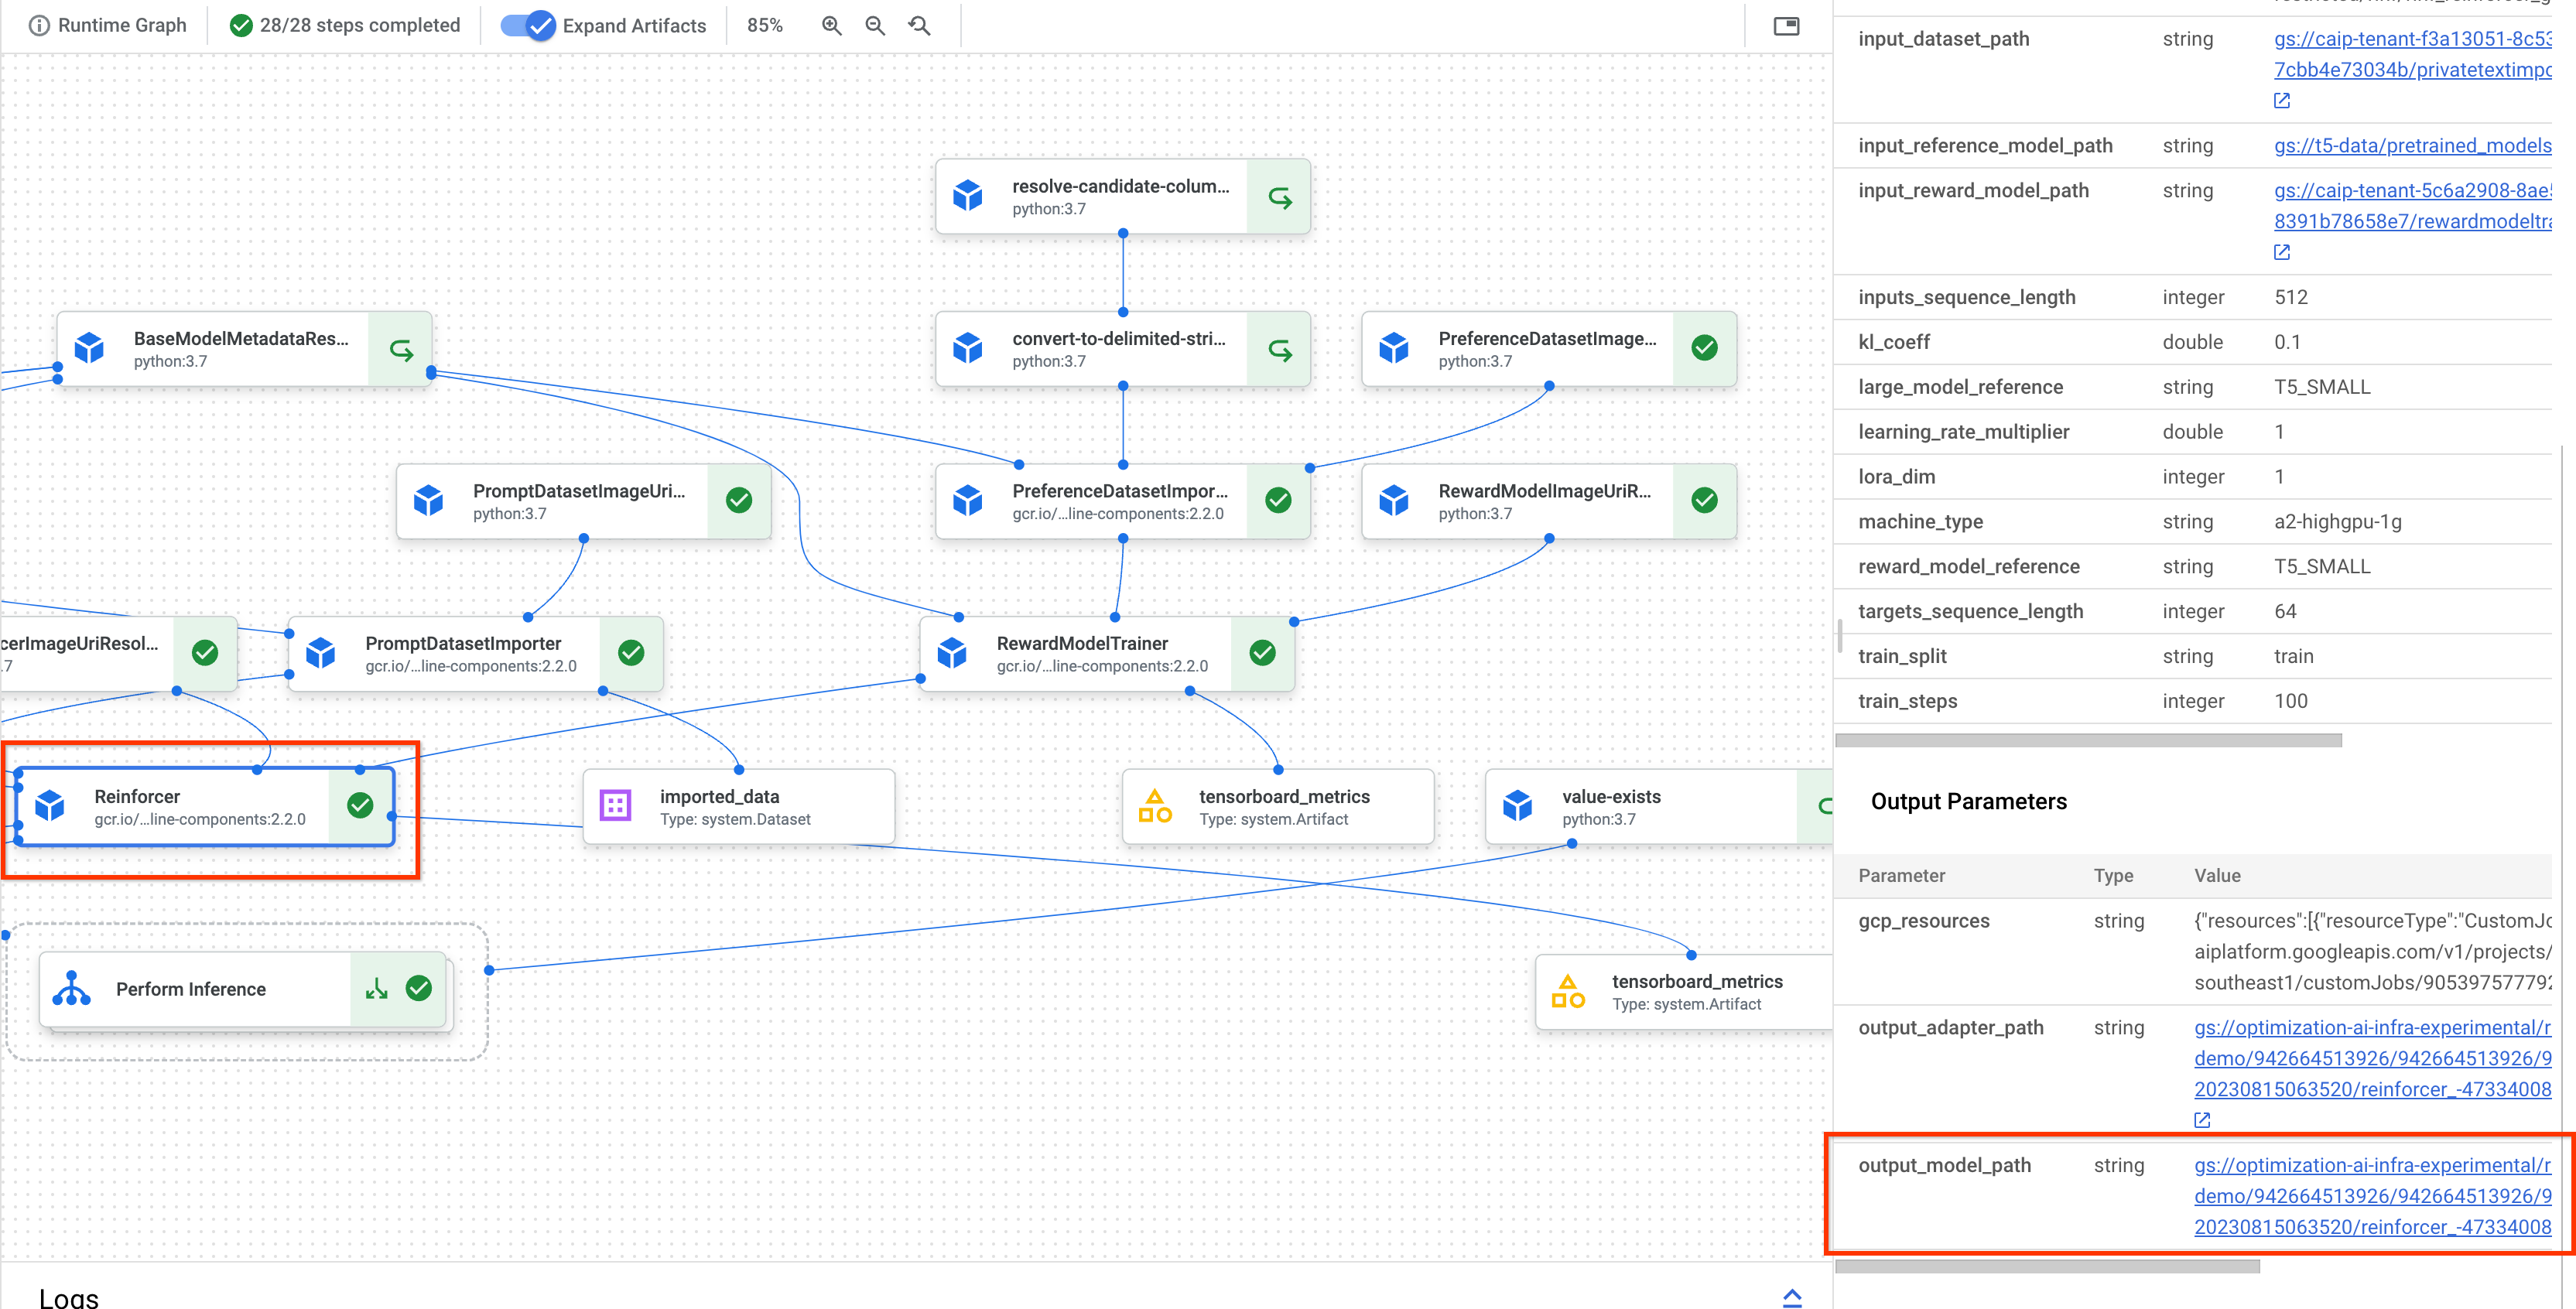

### Online Prediction (only applicable if you are tuning `text-bison@001`)
By default, tuned Bison models are automatically deployed to a Vertex AI Endpoint and can be used for online prediction. The endpoint name can be found in the Vertex Pipelines UI under **create-endpoint-and-deploy-model** > **Output Parameters** > `endpoint_resource_name`.

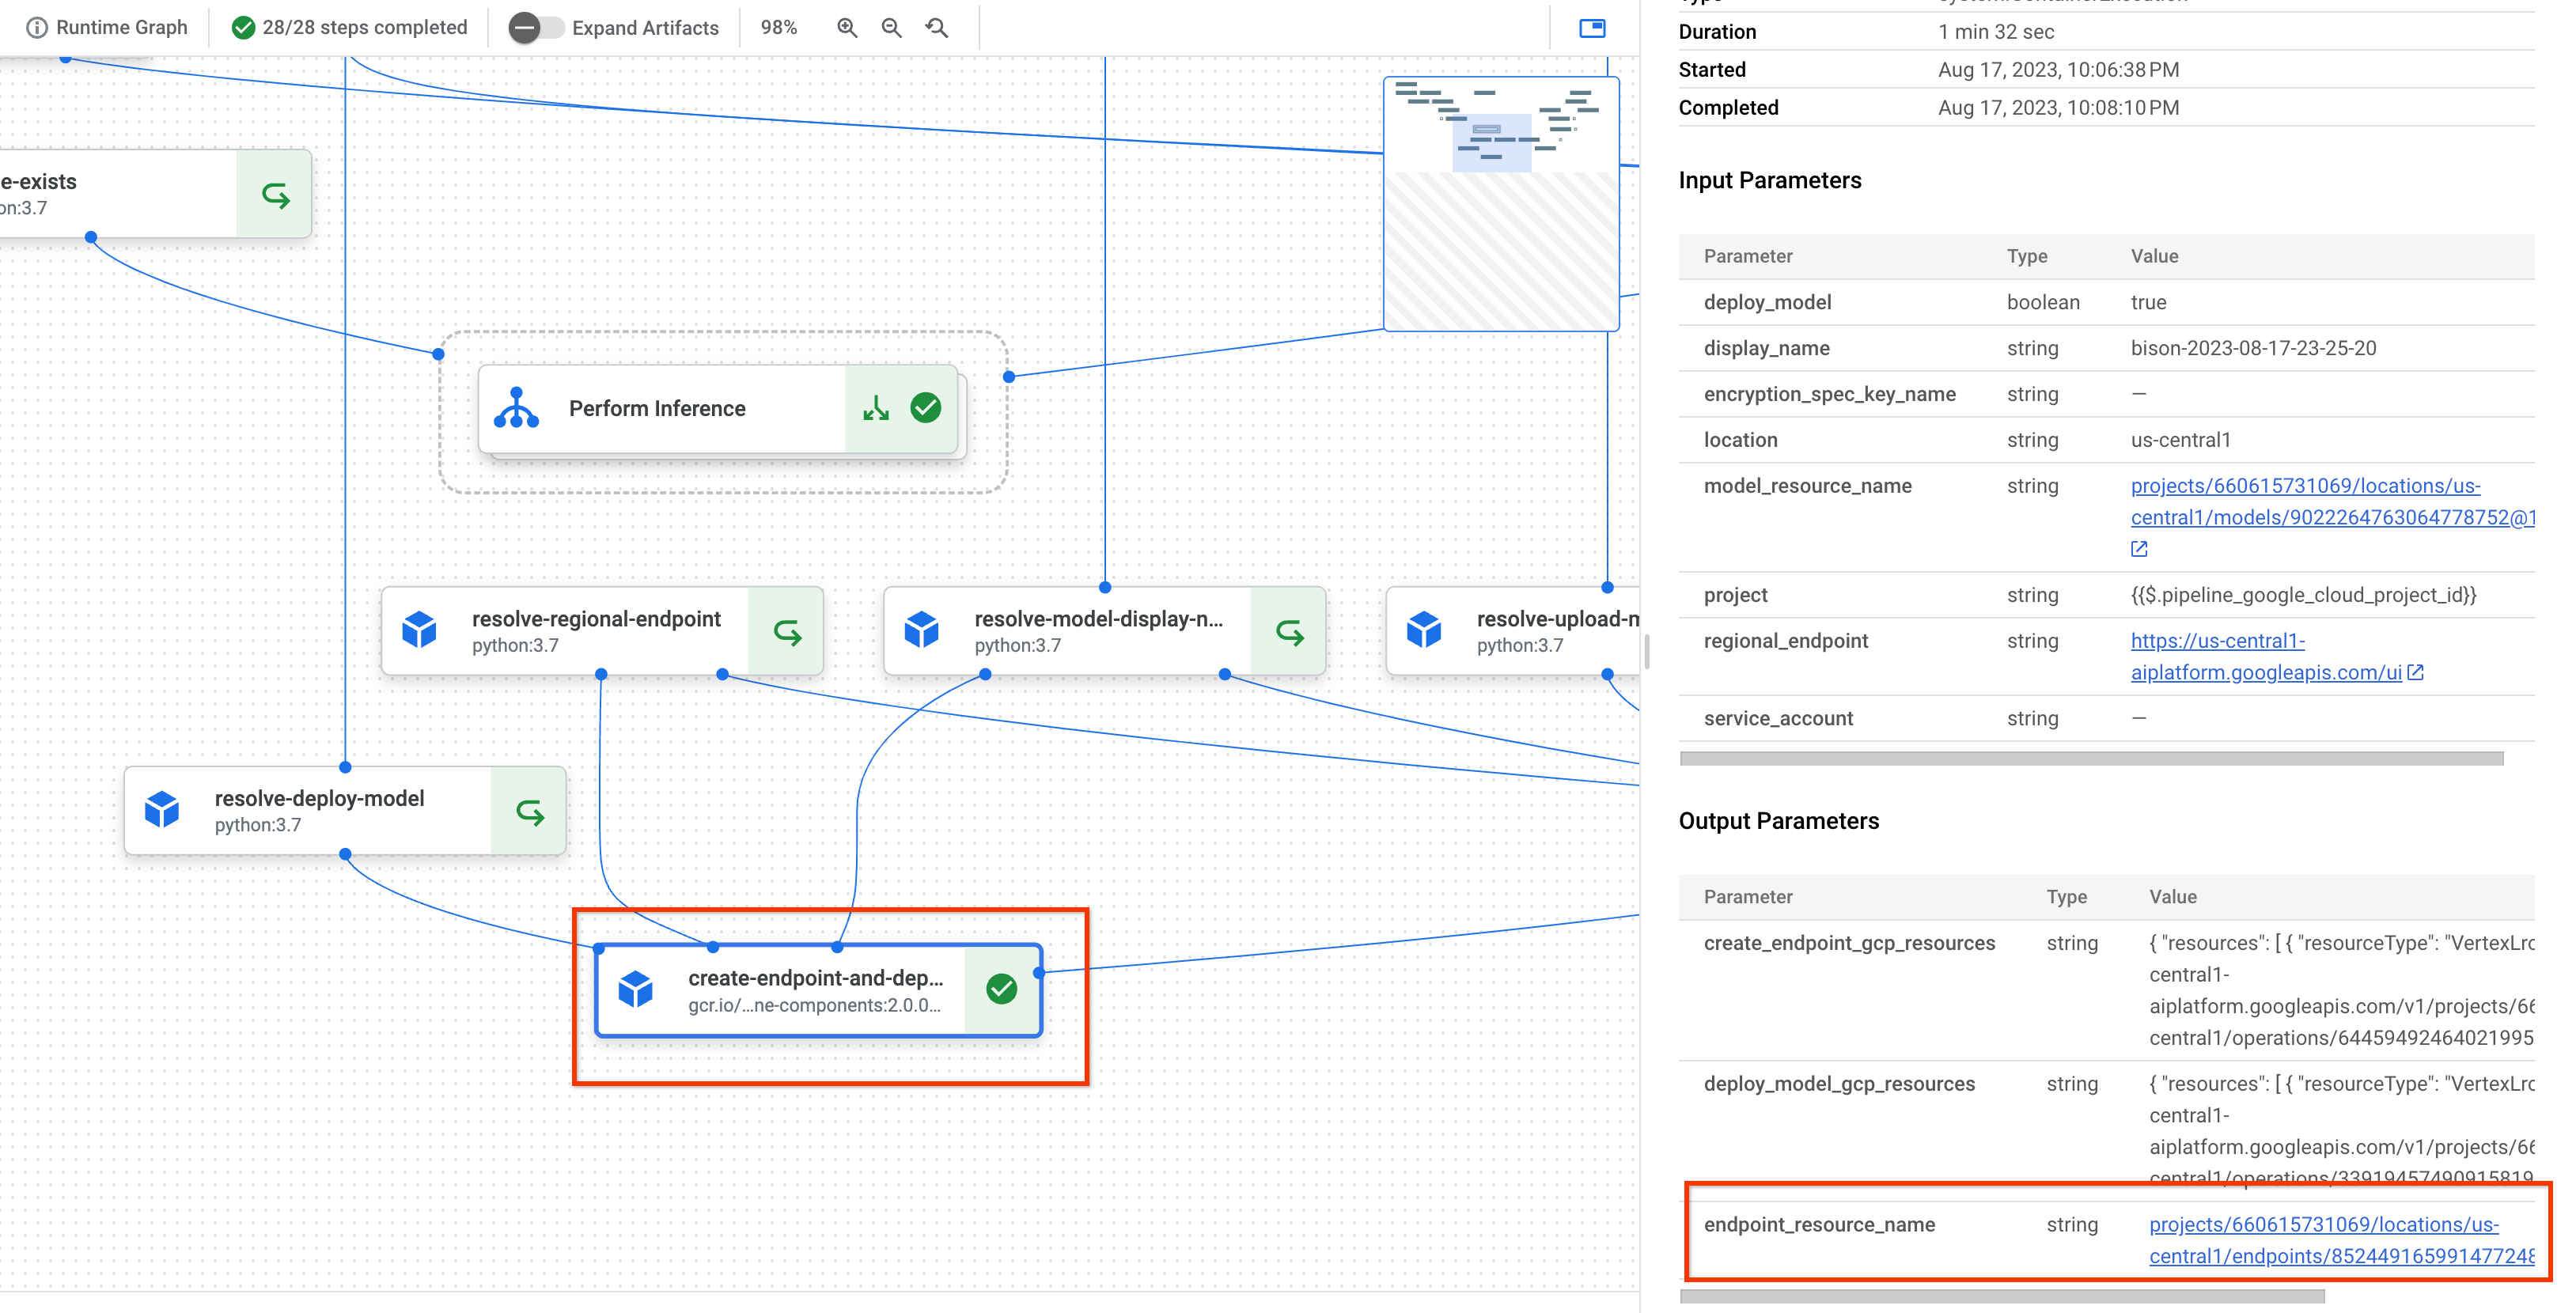

To submit predicitons to the endpoint, Copy the `endpoint_resource_name` into the textbox below in place of `[your_endpoint_resource_name]`.

In [ ]:
ENDPOINT_RESOURCE_NAME = "[your-endpoint-resource-name]"  # @param {type:"string"}

Then, send prediction request to that endpoint using the `predict()` method from the Vertex AI Prediction interface by executing the cell below. This method defines the following parameters:

- `instances`: A list of one or more instances for prediction. Each instance has the format:
    - { "content": the_text_input }
- `parameters`: Parameters passed to the model for the model's predict method. The parameters shown in the example below are the default values.

In [ ]:
if not os.getenv("IS_TESTING"):
    endpoint = aiplatform.Endpoint(ENDPOINT_RESOURCE_NAME)
    print(endpoint)

    endpoint.predict(
        instances=[{"content": "Tell me some ideas combining VR and fitness:"}],
        parameters={
            "temperature": 0.0,
            "maxDecodeSteps": 128,
            "topP": 0.95,
            "topK": 40,
        },
    )

You can also interact with your model using Generative AI Studio. Click on **create-endpoint-and-deploy-model** > **Output Parameters** > `endpoint_resource_name` hyperlink. Then click on the model name > "Deploy & Test" tab > "Open in Prompt Design".

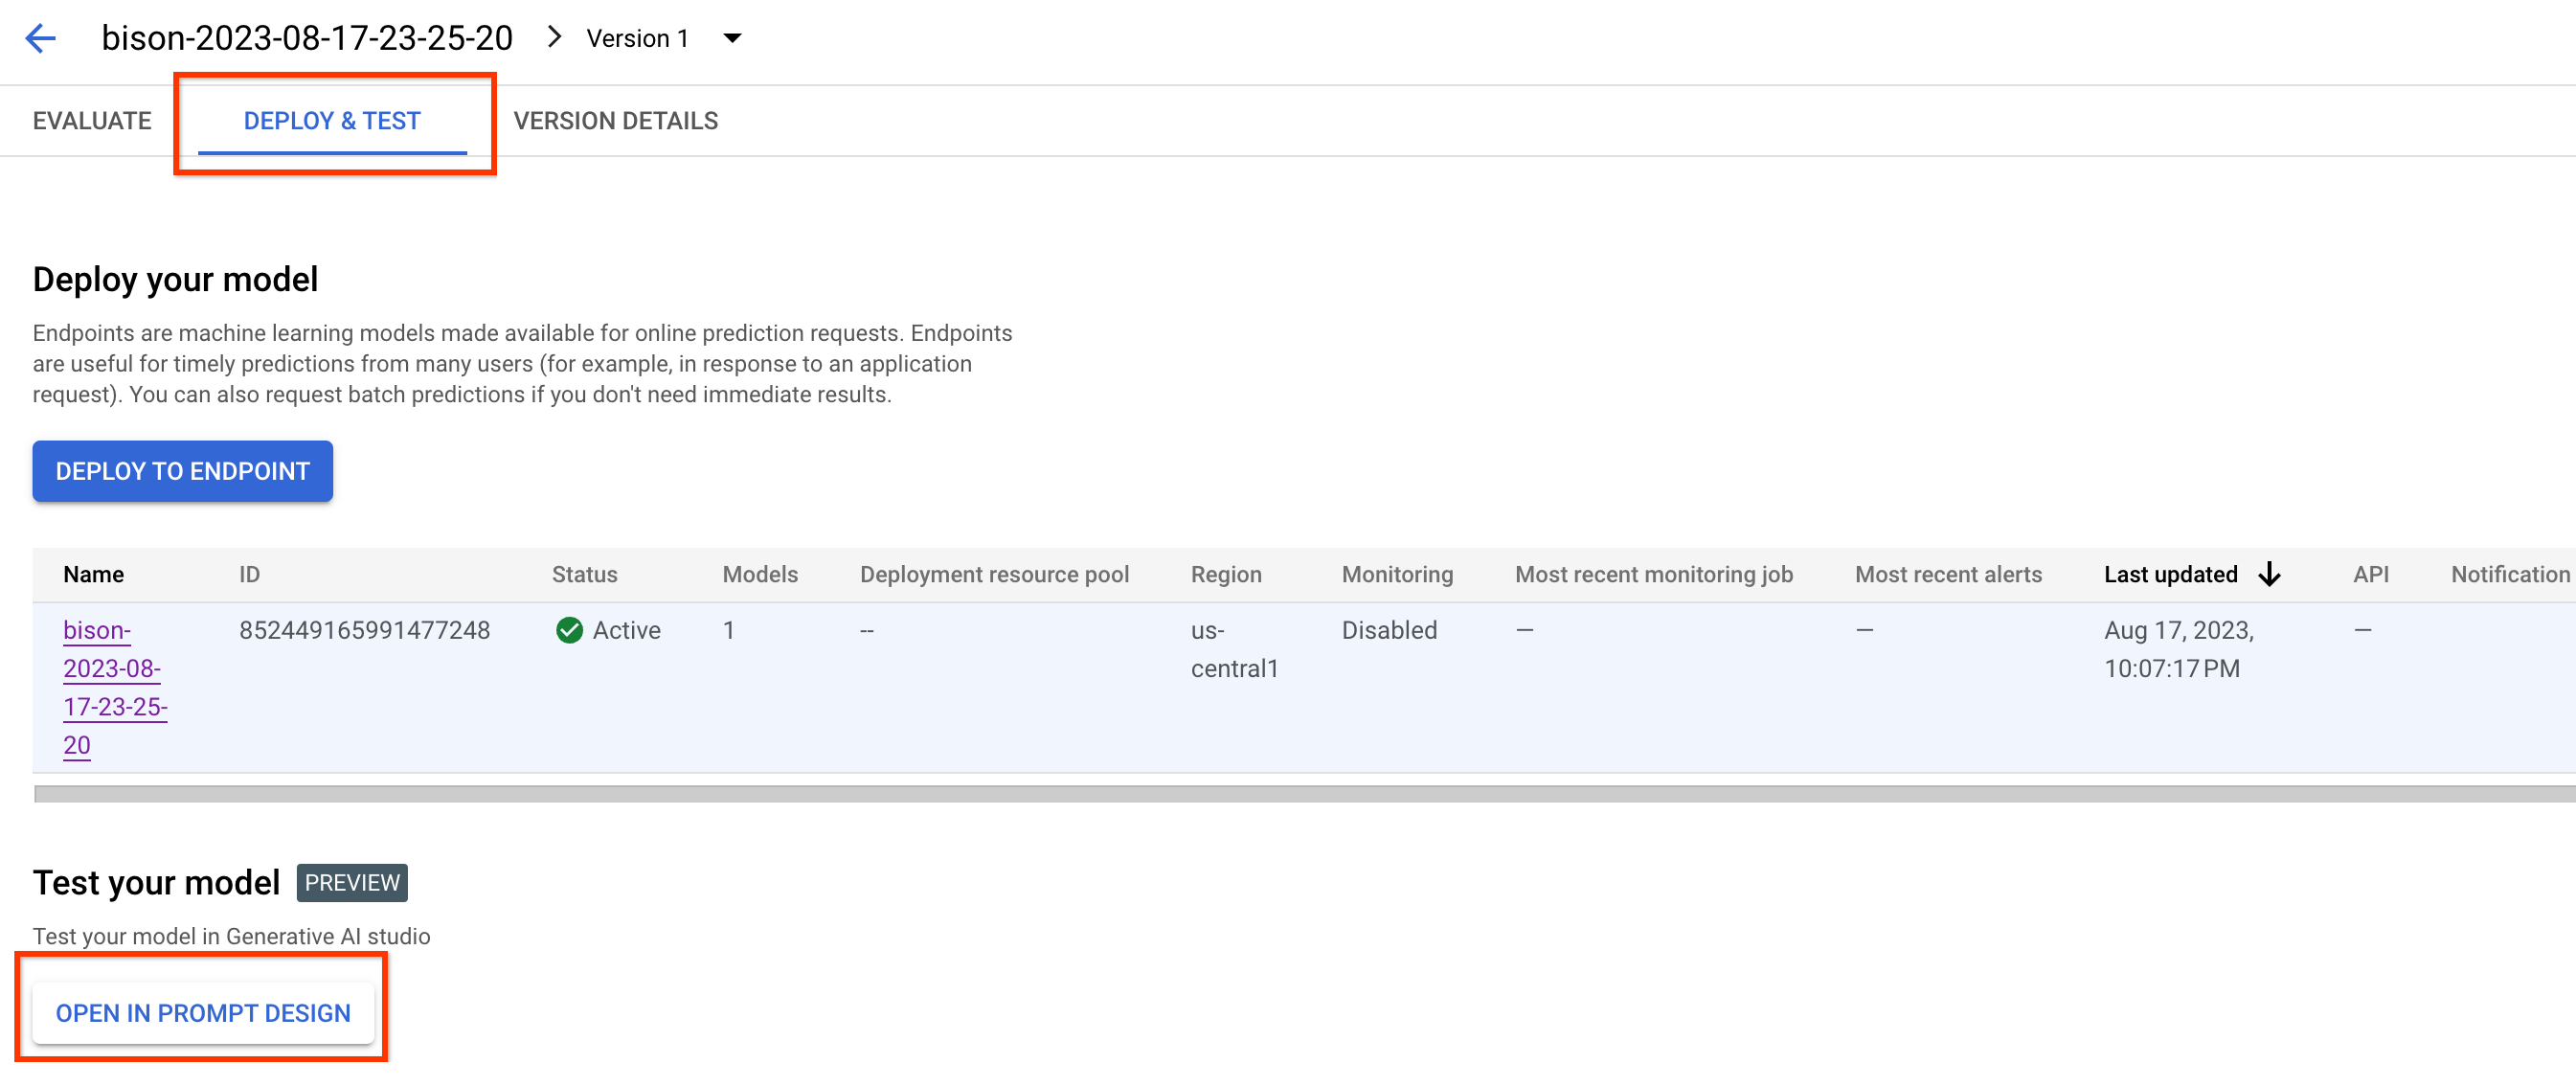

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial.

In [ ]:
delete_bucket = False

job.delete()

if not os.getenv("IS_TESTING"):
    endpoint.undeploy_all()
    endpoint.delete()

    vertex_model = aiplatform.Model(endpoint.gca_resource.deployed_models[0].model)
    vertex_model.delete()

if delete_bucket or os.getenv("IS_TESTING"):
    ! gsutil rm -rf {BUCKET_URI}

! rm rlhf_pipeline.yaml